# Pretrained CLIP + SWIN Transformer on ImageNet

### Hardware Check

In [1]:
def get_hardware_info(use_in_notebook=True, install_packages=True):
    import sys
    import subprocess
    import importlib.util

    if install_packages:
        if importlib.util.find_spec("psutil") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "psutil"], check=True)
        if importlib.util.find_spec("gputil") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "gputil"], check=True)
        if importlib.util.find_spec("py-cpuinfo") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "py-cpuinfo"], check=True)

    # import needed packages
    import platform
    import psutil
    import GPUtil
    from cpuinfo import get_cpu_info

    if use_in_notebook:
        if install_packages and importlib.util.find_spec("ipython") is None:
            subprocess.run([sys.executable, "-m", "pip", "install", "ipython"], check=True)

        from IPython.display import clear_output
        clear_output()
    else:
        pass
        # os.system('cls' if os.name == 'nt' else 'clear')

    print("-"*32, "\nYour Hardware:\n")

    # General
    print("    ---> General <---")
    print("Operatingsystem:", platform.system())
    print("Version:", platform.version())
    print("Architecture:", platform.architecture())
    print("Processor:", platform.processor())

    # GPU-Information
    print("\n    ---> GPU <---")
    gpus = GPUtil.getGPUs()
    for gpu in gpus:
        print("GPU Name:", gpu.name)
        print("VRAM Total:", gpu.memoryTotal, "MB")
        print("VRAM Used:", gpu.memoryUsed, "MB")
        print("Utilization:", gpu.load * 100, "%")
    try:
        import torch
        gpus = [torch.cuda.get_device_name(device_nr) for device_nr in range(torch.cuda.device_count())]
        torch_support = False
        if torch.cuda.is_available():
            torch_support = True
            gpu_str = f"({','.join(gpus)})"
        gpu_addition = f" {gpu_str}" if torch_support else ""
        print(f"PyTorch Support: {torch_support}" + gpu_addition)
    except Exception:
        print(f"PyTorch Support: False")

    try:
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        tf_support = False
        if len(gpus) > 0:
            tf_support = True
            gpu_str = f"({','.join(gpus)})"
        gpu_addition = f" {gpu_str}" if tf_support else ""
        print(f"TensorFlow Support: {tf_support}" + gpu_addition)
    except Exception:
        print(f"TensorFlow Support: False")

    # CPU-Information
    print("\n    ---> CPU <---")
    cpu_info = get_cpu_info()
    print("CPU-Name:", cpu_info["brand_raw"])
    print("CPU Kernels:", psutil.cpu_count(logical=False))
    print("Logical CPU-Kernels:", psutil.cpu_count(logical=True))
    print("CPU-Frequence:", psutil.cpu_freq().max, "MHz")
    print("CPU-Utilization:", psutil.cpu_percent(interval=1), "%")


    # RAM-Information
    print("\n    ---> RAM <---")
    ram = psutil.virtual_memory()
    print("RAM Total:", ram.total // (1024**3), "GB")
    print("RAM Available:", ram.available // (1024**3), "GB")
    print("RAM-Utilization:", ram.percent, "%")

    print(f"\n{'-'*32}")



get_hardware_info(use_in_notebook=True, install_packages=True)

-------------------------------- 
Your Hardware:

    ---> General <---
Operatingsystem: Linux
Version: #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
Architecture: ('64bit', 'ELF')
Processor: x86_64

    ---> GPU <---
GPU Name: NVIDIA A100-SXM4-40GB
VRAM Total: 40960.0 MB
VRAM Used: 0.0 MB
Utilization: 0.0 %
PyTorch Support: True (NVIDIA A100-SXM4-40GB)
TensorFlow Support: False

    ---> CPU <---
CPU-Name: Intel(R) Xeon(R) CPU @ 2.20GHz
CPU Kernels: 6
Logical CPU-Kernels: 12
CPU-Frequence: 0.0 MHz
CPU-Utilization: 0.7 %

    ---> RAM <---
RAM Total: 83 GB
RAM Available: 80 GB
RAM-Utilization: 3.3 %

--------------------------------


### Imports

In [2]:
!pip install timm
!pip install git+https://github.com/openai/CLIP.git
!pip install datasets

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hyv4t6sh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hyv4t6sh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.3.1-py3-none-any.whl.metadata (7.3 kB)
Using cached ftfy-6.3.1-py3-none-any.whl (44 kB)
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=f42490ea848267461a662f664aa5f5617d4b7f48b1bf799b73df9e586ca47718
  Stored in directory: /tmp/pip-ephem-wheel-cache-0d2kmzxe/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [3]:
import platform
import os
import shutil
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn

import torchvision
from torchvision import transforms

# we use hugging face https://github.com/huggingface/pytorch-image-models?tab=readme-ov-file#introduction
import timm

import clip

### Helper

In [4]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    title can be None, str or a list of strings.
    """
    import cv2

    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
            img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[3]))
        else:
            # there could be cases where this is wrong
            img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[3], 1))
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}'' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    ax = ax.ravel()
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            cur_img = cur_img
            cmap = "gray"

        cur_ax.imshow(cur_img, cmap=cmap)

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

### Constants

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Load Data

Loading, preparing and analyzing the ImageNet100 Dataset.

Go to .. and download the "Development kit (Task 1 & 2)" with the file name "ILSVRC2012_devkit_t12.tar.gz" and upload it here in ./data .

Getting a Kaggle API Key (if not already have):
    1. Go to https://www.kaggle.com/ and create or sign in your account
    2. Click on your profile picture > Settings and go to API
    3. Click on 'Create New Token' and the 'kaggle.json' fie should download automatically
    4. Now you can use the following code to load your json file and download the imagenet dataset


In [6]:
from datasets import load_dataset

dataset = load_dataset("clane9/imagenet-100")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.87k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

train-00000-of-00017.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00001-of-00017.parquet:   0%|          | 0.00/469M [00:00<?, ?B/s]

train-00002-of-00017.parquet:   0%|          | 0.00/471M [00:00<?, ?B/s]

train-00003-of-00017.parquet:   0%|          | 0.00/513M [00:00<?, ?B/s]

train-00004-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00005-of-00017.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00006-of-00017.parquet:   0%|          | 0.00/522M [00:00<?, ?B/s]

train-00007-of-00017.parquet:   0%|          | 0.00/429M [00:00<?, ?B/s]

train-00008-of-00017.parquet:   0%|          | 0.00/474M [00:00<?, ?B/s]

train-00009-of-00017.parquet:   0%|          | 0.00/473M [00:00<?, ?B/s]

train-00010-of-00017.parquet:   0%|          | 0.00/451M [00:00<?, ?B/s]

train-00011-of-00017.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00012-of-00017.parquet:   0%|          | 0.00/468M [00:00<?, ?B/s]

train-00013-of-00017.parquet:   0%|          | 0.00/457M [00:00<?, ?B/s]

train-00014-of-00017.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

train-00015-of-00017.parquet:   0%|          | 0.00/454M [00:00<?, ?B/s]

train-00016-of-00017.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/314M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/126689 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/17 [00:00<?, ?it/s]

In [7]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 126689
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5000
    })
})


In [8]:
dataset["train"][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=213x160>,
 'label': 0}

In [9]:
class_name_to_id = dict()
class_id_to_name = dict()
for i, name in enumerate(dataset["train"].features["label"].names):
  class_id_to_name[i] = name
  class_name_to_id[name] = i

class_id_to_name

{0: 'bonnet, poke bonnet',
 1: 'green mamba',
 2: 'langur',
 3: 'Doberman, Doberman pinscher',
 4: 'gyromitra',
 5: 'Saluki, gazelle hound',
 6: 'vacuum, vacuum cleaner',
 7: 'window screen',
 8: 'cocktail shaker',
 9: 'garden spider, Aranea diademata',
 10: 'garter snake, grass snake',
 11: 'carbonara',
 12: 'pineapple, ananas',
 13: 'computer keyboard, keypad',
 14: 'tripod',
 15: 'komondor',
 16: 'American lobster, Northern lobster, Maine lobster, Homarus americanus',
 17: 'bannister, banister, balustrade, balusters, handrail',
 18: 'honeycomb',
 19: 'tile roof',
 20: 'papillon',
 21: 'boathouse',
 22: 'stinkhorn, carrion fungus',
 23: 'jean, blue jean, denim',
 24: 'Chihuahua',
 25: 'Chesapeake Bay retriever',
 26: 'robin, American robin, Turdus migratorius',
 27: 'tub, vat',
 28: 'Great Dane',
 29: 'rotisserie',
 30: 'bottlecap',
 31: 'throne',
 32: 'little blue heron, Egretta caerulea',
 33: 'rock crab, Cancer irroratus',
 34: 'Rottweiler',
 35: 'lorikeet',
 36: 'Gila monster, He

In [10]:
dataset["train"][0]["image"].size

(213, 160)

In [11]:
class ImageNet(torch.utils.data.Dataset):
  def __init__(self, data, transforms, *args):
    super().__init__(*args)
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    cur_pil_image, cur_label = self.data[idx]["image"], self.data[idx]["label"]
    cur_pil_image = self.transforms(cur_pil_image)
    return cur_pil_image, cur_label

In [12]:
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    # transforms.RandomResizedCrop(224),
    transforms.Resize([224, 224]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# define train and validation data
train_val_data = dataset["train"]
train_size = int( 0.8*len(train_val_data) )
val_size = int( len(train_val_data) - train_size )
train_data, val_data = torch.utils.data.random_split(train_val_data, [train_size, val_size])

# apply torch dataset wrapper
train_data = ImageNet(train_data, train_transform)
val_data = ImageNet(val_data, test_val_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_data,
    batch_size=4,
    shuffle=True,
    num_workers=4,
)
val_dataloader = torch.utils.data.DataLoader(
    val_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)

# define testdata
test_data = ImageNet(dataset["validation"], test_val_transform)
test_dataloader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
)


show some samples

Got images with shape: torch.Size([9, 224, 224, 3])
Transformed shape to: torch.Size([9, 224, 224, 3])
Using 'seaborn-v0_8'' plotting style.
Making you a beautiful plot...


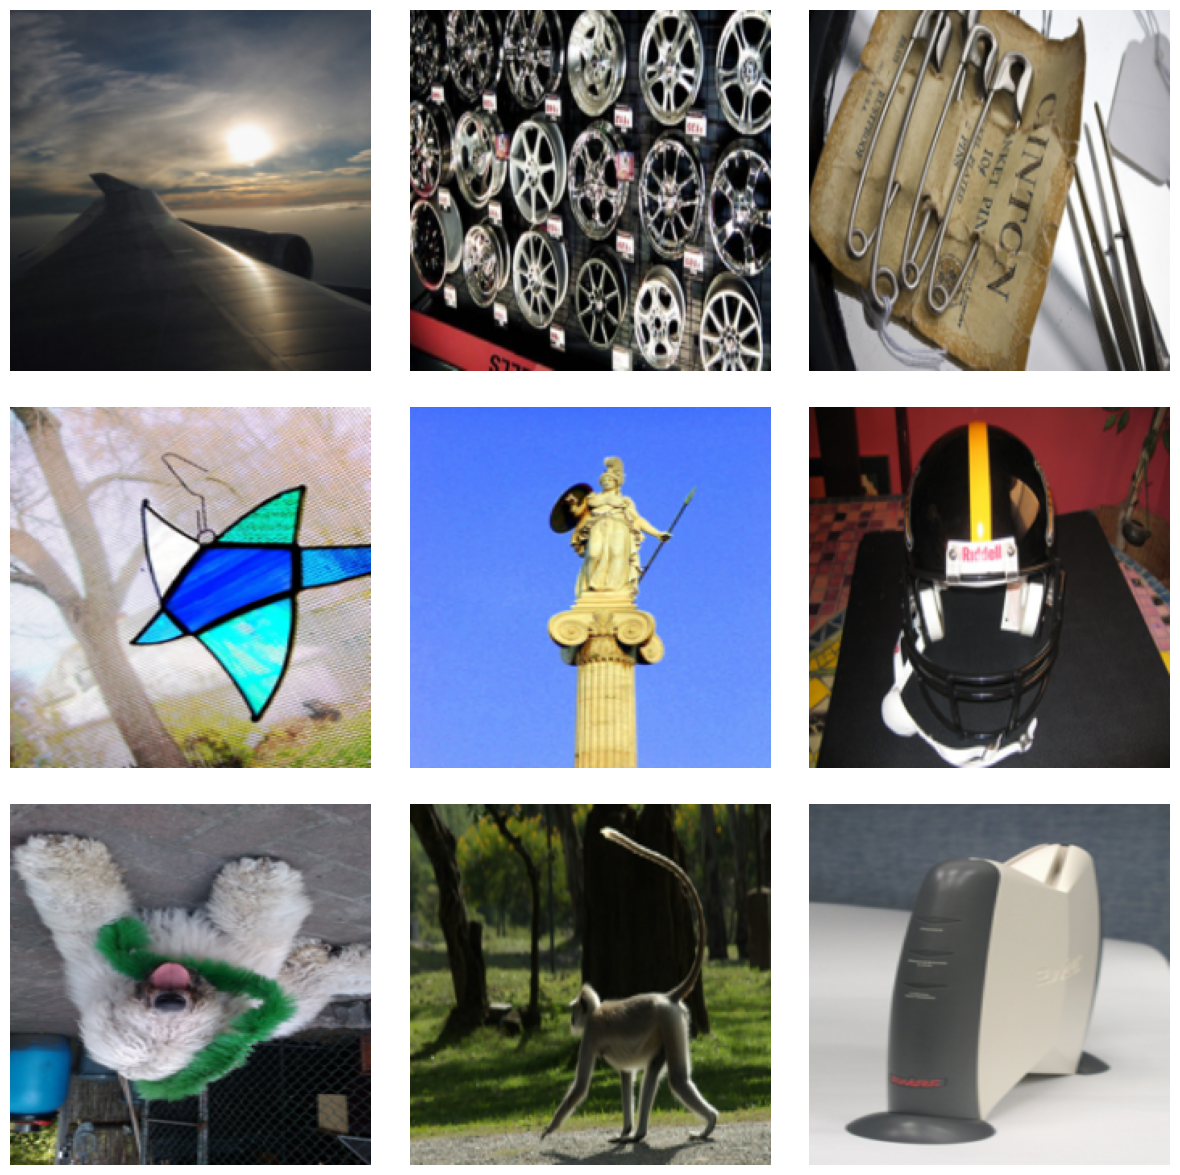

In [13]:
collected_images = []
for img_batch, label_batch in train_dataloader:
  for img_num in range(img_batch.shape[0]):
    collected_images += [img_batch[img_num]]
    if len(collected_images) >= 9:
      break
  if len(collected_images) >= 9:
    break

imshow(torch.stack(collected_images).permute(0, 2, 3, 1), title=None, image_width=5, axis=False,
           color_space="RGB", cols=3, save_to=None,
           hspace=0.1, wspace=0.1,
           use_original_sytle=False, invert=False)

### Loding Models

#### Load Pretrained SWIN


In [14]:
help(timm.create_model('swin_base_patch4_window7_224', pretrained=True))

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

Help on SwinTransformer in module timm.models.swin_transformer object:

class SwinTransformer(torch.nn.modules.module.Module)
 |  SwinTransformer(img_size: Union[int, Tuple[int, int]] = 224, patch_size: int = 4, in_chans: int = 3, num_classes: int = 1000, global_pool: str = 'avg', embed_dim: int = 96, depths: Tuple[int, ...] = (2, 2, 6, 2), num_heads: Tuple[int, ...] = (3, 6, 12, 24), head_dim: Optional[int] = None, window_size: Union[int, Tuple[int, int]] = 7, always_partition: bool = False, strict_img_size: bool = True, mlp_ratio: float = 4.0, qkv_bias: bool = True, drop_rate: float = 0.0, proj_drop_rate: float = 0.0, attn_drop_rate: float = 0.0, drop_path_rate: float = 0.1, embed_layer: Callable = <class 'timm.layers.patch_embed.PatchEmbed'>, norm_layer: Union[str, Callable] = <class 'torch.nn.modules.normalization.LayerNorm'>, weight_init: str = '', **kwargs)
 |  
 |  Swin Transformer
 |  
 |  A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Wind

In [15]:
import torch.nn.functional as F

class SwinForClassification(nn.Module):
    def __init__(self):
        super(SwinForClassification, self).__init__()
        self.model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, 100)    # self.model.head.in_features = 1024

    def forward(self, x):
        # Feature extraction
        x = self.model.forward_features(x)    # [batch_size, 7, 7, 1024]
        x = x.permute(0, 3, 1, 2)    # [batch_size, 1024, 7, 7]
        # print(x.shape)

        # Reducing to 1x1
        x = F.adaptive_avg_pool2d(x, (1, 1))  # [batch_size, 1024, 1, 1]
        # print(x.shape)

        # Flatten to [batch_size, num_features]
        x = x.view(x.size(0), -1)    # [batch_size, 1024]
        # print(x.shape)

        # Classification
        x = self.model.head(x)
        return x

In [16]:
# Load pretrained Swin model (base version, pretrained on full ImageNet-1K)
model_swin = SwinForClassification()
# torch.nn.init.xavier_uniform_(model_swin.head.weight)
# torch.nn.init.zeros_(model_swin.head.bias)

#### Loading CLIP

In [17]:
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.4MiB/s]


### Small Fine-Tuning Training

In [18]:
def test(model, data_loader, criterion, device):
    model = model.to(device)
    model.eval()
    return_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            # prediction/forward
            outputs = model(images)

            # Check output shape
            # print(f"Output shape: {outputs.shape}")  # For debugging
            # Ensure labels are of shape [batch_size] (no spatial dimensions)
            # print(f"Labels shape: {labels.shape}")  # For debugging

            # if multiple images: calc mean output
            loss = criterion(outputs, labels)
            return_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = return_loss / total
    accuracy = correct / total

    print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    return avg_loss, accuracy

def training(model, device):
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

  for epoch in range(10):
      model.train()
      for images, labels in train_dataloader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      print(f"Epoch {epoch+1} done.")
      # test(model=model, data_loader=val_dataloader, criterion=criterion, device=device)

In [19]:
training(model_swin, device)

Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.


In [23]:
if True:
  from google.colab import drive
  drive.mount('/content/drive')

  save_path = '/content/drive/MyDrive/models'
  name = 'swin_model.pth'

  import os
  os.makedirs(save_path, exist_ok=True)

  torch.save(model_swin.state_dict(), os.path.join(save_path, name))

Mounted at /content/drive


In [20]:
# training(model_convnext, device)

### Evaluation

In [21]:
test(model_swin, test_dataloader, criterion=nn.CrossEntropyLoss(), device=device)

Test Loss: 0.8703, Accuracy: 78.88%


(0.8702988455030208, 0.7888)

In [22]:
correct = 0
wrong = 0

different_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
      images, labels = images.to(device), labels.to(device)
      # preprocess(images).unsqueeze(0)
      image_features = model.encode_image(images)

      # text_inputs = clip.tokenize([f"a photo of a {class_id_to_name[c]}" for c in labels.tolist()]).to(device)
      all_prompts = [f"a photo of a {name}" for name in class_id_to_name.values()]
      text_inputs = clip.tokenize(all_prompts).to(device)
      text_features = model.encode_text(text_inputs)

      # matrice multiplication of similarity between text and image encodings
      logits_per_image = image_features @ text_features.T
      # similarity to probability -> prediction
      probs = logits_per_image.softmax(dim=-1)

      # Top prediction
      idx = 0
      top_prob, top_label = probs.topk(1)
      for cur_top_prob, cur_top_label in zip(top_prob, top_label):
        # print(f"Predicted: {class_id_to_name[cur_top_label.item()]} (prob={cur_top_prob.item():.2f}) = True is: {class_id_to_name[labels.tolist()[idx]]}")
        if labels.tolist()[idx] not in different_labels:
          different_labels += [labels.tolist()[idx]]
        if cur_top_label.item() == labels.tolist()[idx]:
          correct += 1
        else:
          wrong += 1
        idx += 1

print(f"Top-1 Accuracy: {(correct/(correct+wrong))*100:.2f}%")
# different_labels

Top-1 Accuracy: 57.56%
